In [1]:
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tensorflow import keras
from datetime import datetime
import random

In [2]:
samples = 50

m = 2
xs = [i * m for i in range(samples)]
c = 50

ms = [m for _ in range(samples)]
cs = [c for _ in range(samples)]
ys = [m * x + c for x in xs]
noise = [random.randint(0,50) for _ in range(samples)]

data = {
    'ms': ms,
    'xs': xs,
    'cs': cs,
    'noise': noise,
    'ys': ys
}

df = pd.DataFrame(data=data)
df.head(5)

,ms,xs,cs,noise,ys
0,2,0,50,30,50
1,2,2,50,10,54
2,2,4,50,29,58
3,2,6,50,41,62
4,2,8,50,35,66


In [3]:
def maximum_absolute_scaling(df):
    df_scaled = df.copy()
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled

In [4]:
scaled = maximum_absolute_scaling(df)
scaled.head(5)

,ms,xs,cs,noise,ys
0,1.0,0.000000,1.0,0.612245,0.203252
1,1.0,0.020408,1.0,0.204082,0.219512
2,1.0,0.040816,1.0,0.591837,0.235772
3,1.0,0.061224,1.0,0.836735,0.252033
4,1.0,0.081633,1.0,0.714286,0.268293


In [5]:
columns = ['ms', 'xs', 'cs', 'noise']

X_train = df[columns]
y_train = df['ys']

X_train.shape

(50, 4)

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=[4], activation='relu'))
model.add(tf.keras.layers.Dense(units=4, input_shape=[4], activation='relu'))
model.add(tf.keras.layers.Dense(units=1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [7]:
epochs_hist = model.fit(X_train, y_train, epochs=2000)

Epoch 1/2000
2/2 [==============================] - 0s 33ms/step - loss: 28808.2734
Epoch 2/2000
2/2 [==============================] - 0s 6ms/step - loss: 28653.1016
Epoch 3/2000
2/2 [==============================] - 0s 6ms/step - loss: 28503.8496
Epoch 4/2000
2/2 [==============================] - 0s 6ms/step - loss: 28349.7402
Epoch 5/2000
2/2 [==============================] - 0s 6ms/step - loss: 28174.8945
Epoch 6/2000
2/2 [==============================] - 0s 6ms/step - loss: 28019.6328
Epoch 7/2000
2/2 [==============================] - 0s 6ms/step - loss: 27837.7793
Epoch 8/2000
2/2 [==============================] - 0s 6ms/step - loss: 27654.4043
Epoch 9/2000
2/2 [==============================] - 0s 6ms/step - loss: 27471.8984
Epoch 10/2000
2/2 [==============================] - 0s 6ms/step - loss: 27289.2090
Epoch 11/2000
2/2 [==============================] - 0s 6ms/step - loss: 27103.6152
Epoch 12/2000
2/2 [==============================] - 0s 6ms/step - loss: 26925.9316


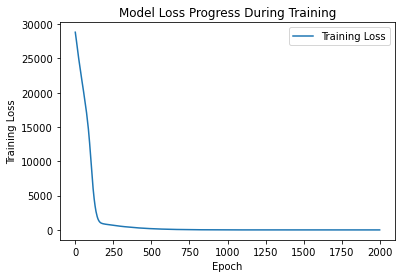

In [8]:
plt.plot(epochs_hist.history['loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Training Loss'])

In [9]:
x = 10

tdata = {
    'ms': [2],
    'xs': [x],
    'cs': [50],
    'noise': [25]
}
test =  pd.DataFrame(tdata)
test

,ms,xs,cs,noise
0,2,10,50,25


In [10]:
model.predict(test)

1/1 [==============================] - 0s 68ms/step


array([[70.010254]], dtype=float32)

In [11]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [12]:
conn = Neo4jConnection(uri="neo4j://localhost:7687", user="neo4j", pwd="password")

In [13]:
weights = [model.layers[i].get_weights()[0].tolist() for i in range(len(model.layers))]
biases = [model.layers[i].bias.numpy().tolist() for i in range(len(model.layers))]
output_w = weights.pop()
output_b = biases.pop()

[[[-0.4557737708091736, 0.5421625971794128, -0.3647845983505249, 0.10064659267663956], [0.35842567682266235, 0.38996002078056335, 0.368621289730072, 1.224179983139038], [0.5376231670379639, -0.7163065671920776, -0.8628119826316833, 0.07654043287038803], [-0.48845288157463074, 0.12448976933956146, -0.6249617338180542, 0.7416009902954102]], [[-0.3259841203689575, 0.9133933782577515, 0.6648973226547241, -0.8597714304924011], [0.49795621633529663, 0.06611849367618561, -0.0721655786037445, 0.7625370621681213], [0.7934598326683044, 0.09739869832992554, -0.5808207988739014, -0.6331388354301453], [-0.6368775367736816, 0.4932668209075928, 0.5823979377746582, -0.09333685785531998]]]
[[-0.4123409390449524], [1.2170006036758423], [0.9105810523033142], [-1.0105677843093872]]
4
[[0.188421368598938, -0.13321465253829956, 0.0, 0.09620606154203415], [0.0, 0.14176027476787567, 0.13746896386146545, -0.09332890063524246]]
[0.1450825333595276]


In [14]:
def input_nodes():
    for i in range(len(columns)):
        query = f"CREATE (i: Input {{name: '{columns[i]}'}})"
        conn.query(query, db="nndb")

In [15]:
def hidden_layer_nodes():
    for i in range(len(biases)):
        for j in range(len(biases[i])):
            query = f"CREATE (h: HiddenLayer{i} {{bias: {biases[i][j]}, name: 'hidden_layer_{i}_node_{j}'}})"
            conn.query(query, db="nndb")

In [16]:
def output_nodes():
    query = f"CREATE (o: Output {{bias: {output_b[0]}, name: 'output_node'}})"
    conn.query(query, db="nndb")

In [17]:
def input_weights():
    in_weights = weights[0]
    for i in range(len(in_weights)):
        for j in range(len(in_weights[i])):
            query = f"""
                MATCH
                    (i: Input),
                    (h: HiddenLayer0)
                WHERE i.name = '{columns[i]}'
                AND h.name = 'hidden_layer_0_node_{j}'
                CREATE (i)-[w: Weight {{weight: {in_weights[i][j]}}}]->(h)
                RETURN i, h
            """
            conn.query(query, db="nndb")

In [18]:
def output_weights():
    last_hidden_layer = len(biases) - 1
    for i in range(len(output_w)):
        query = f"""
            MATCH 
                (h: HiddenLayer{last_hidden_layer}),
                (o: Output)
            WHERE h.name = 'hidden_layer_{last_hidden_layer}_node_{i}'
            CREATE (h)-[w: Weight {{weight: {output_w[i][0]}}}]->(o)
        """
        conn.query(query, db="nndb")

In [19]:
def hidden_layer_weights():
    for i in range(len(weights)):
        if i == 0:
            continue
        for j in range(len(weights[i])):
            for k in range(len(weights[i][j])):
                query = f"""
                    MATCH
                        (h0: HiddenLayer{i - 1}),
                        (h1: HiddenLayer{i})
                    WHERE h0.name = 'hidden_layer_{i - 1}_node_{j}'
                    AND h1.name = 'hidden_layer_{i}_node_{k}'
                    CREATE (h0)-[w: Weight {{weight: {weights[i][j][k]}}}]->(h1)
                """
                conn.query(query, db="nndb") 
            

In [20]:
conn.query("CREATE OR REPLACE DATABASE nndb")
input_nodes()
hidden_layer_nodes()
output_nodes()
input_weights()
hidden_layer_weights()
output_weights()